# Juice Examples
In this notebook, we will demonstrate `Juice` a Julia library that offers efficient routines to compile, learn and perform inference on `Logic Circuits` and `Probabilistic Circuits`. The demo includes:

   - Creating Circuits
   - Checking Structural Properties
   - Circuit Transformations
   - Tractable Queries
   - Parameter Learning and Structure Learning
   - Benchmarks and GPU accelerated computing  

### Setup
Uncomment `] instantiate`  to instantiate your environment if its not instantiated already

Can also use `] status` to see what packages are installed and their version.

In [1]:
# ] instantiate

In [2]:
] status

Status `/space/pashak/.julia/dev/JuiceExamples/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [336ed68f] CSV v0.8.2
  [052768ef] CUDA v2.3.0
  [a93c6f00] DataFrames v0.21.8
  [a7847b3b] LogicCircuits v0.2.2
  [2396afbe] ProbabilisticCircuits v0.2.2
  [b4f28e30] TikzGraphs v1.1.0
  [37f6aa50] TikzPictures v3.3.1
  [10745b16] Statistics


In [3]:
using LogicCircuits
using ProbabilisticCircuits
using DataFrames
using BenchmarkTools

In [4]:
# Workaround for tikz plots in the notebook!
#    Also note that for plots to work succesfully, you need to have LaTeX installed. 
#    Check TikzGraphs.jl, TikzPictures.jl documentation for more details!

#    For example, on Ubuntu can do the installation as follows:
#      - sudo apt-get -qq update
#      - sudo apt install -y pdf2svg texlive-latex-base texlive-binaries texlive-pictures texlive-latex-extra texlive-luatex 

using TikzPictures
TikzPictures.standaloneWorkaround(true)

In [5]:
# This should print true, otherwise your cuda setup is not working with julia
#    in that case follow instructions here: https://juliagpu.github.io/CUDA.jl/dev/installation/overview/
using CUDA
CUDA.functional()

true

In [6]:
# By default the first gpu (device 0) is used. To use another gpu, for example the second gpu, uncomment this code
# CUDA.device!(1)

## Create a Circuit
1. We can handcraft a Probabilistic Circuit by using `+` and `*` operators easily.

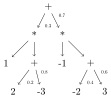

In [7]:
X1, X2, X3 = literals(ProbCircuit, 3)
pc = 0.3 * (X1[1] * 
             (0.2X2[1] + 0.8X3[2])) + 
     0.7 * (X1[2] *
             (0.4X2[2] + 0.6X3[1]))
plot(pc)

2. Some circuit statistics

In [8]:
println("Logical formula of this circuit: ", tree_formula_string(pc))
println("Some circuit statistics: ")
println("# variables : ", num_variables(pc))
println("# nodes : ", num_nodes(pc))
println("# edges : ", num_edges(pc))
println("# parameters : ", num_parameters(pc))

Logical formula of this circuit: ((1 ⋀ (2 ⋁ -3)) ⋁ (-1 ⋀ (-2 ⋁ 3)))
Some circuit statistics: 
# variables : 3
# nodes : 11
# edges : 10
# parameters : 6


## Structure properties
- Circuits satisfying certain structure properties can answer different queries in tractable time. Like smoothness , determinism, decomposability for and structure decomposability, You can ask if the given circuit satisfies such constrains by `isproperty`, for example `issmooth(pc)`
1. Is the circuit **smooth**?
- A sum node is smooth if its children depend of the same variable sets

In [9]:
c1 = 0.4 * X1[1] + 0.6 * X1[2]
c2 = 0.4 * X1[1] + 0.6 * X2[2]
println("Is ", tree_formula_string(c1), " smooth : ", issmooth(c1))
println("Is ", tree_formula_string(c2), " smooth : ", issmooth(c2))

Is (1 ⋁ -1) smooth : true
Is (1 ⋁ -2) smooth : false


In [10]:
issmooth(pc)

false

2. Is the circuit **deterministic**?
- A sum node is deterministic if the output of only one children is non zero for any input

In [11]:
c1 = X1[1] * X2[1] + X1[1] * X2[2]
c2 = X1[1] * X2[1] + X1[1] * X2[1]
println("Is ", tree_formula_string(c1), " deterministic : ", isdeterministic(c1))
println("Is ", tree_formula_string(c2), " deterministic : ", isdeterministic(c2))

Is ((1 ⋀ 2) ⋁ (1 ⋀ -2)) deterministic : true
Is ((1 ⋀ 2) ⋁ (1 ⋀ 2)) deterministic : false


3. Is the circuit **decomposable**?
- A product node is decomposable if its children depend on disjoint sets of variables

In [12]:
isdecomposable(pc)

true

In [13]:
c1 = X1[1] * X2[1] * X3[1]
c2 = X1[1] * X1[1] * X3[1]
println("Is ", tree_formula_string(c1), " decomposable : ", isdecomposable(c1))
println("Is ", tree_formula_string(c2), " decomposable : ", isdecomposable(c2))

Is (1 ⋀ 2 ⋀ 3) decomposable : true
Is (1 ⋀ 1 ⋀ 3) decomposable : false


4. Is the circuit **structured-decomposable**?
- A product node is structured decomposable if decomposes according to a node in a vtree

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -3)) decomposable : true
Is ((1 ⋀ 2) ⋁ (-1 ⋀ -3)) structured decomposable : false
Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2)) structured decomposable : true


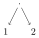

In [14]:
c1 = 0.3 * (X1[1] * X2[1]) + 
     0.7 * (X1[2] * X3[2])
c2 = 0.3 * (X1[1] * X2[1]) + 
     0.7 * (X1[2] * X2[2])
println("Is ", tree_formula_string(c1), " decomposable : ", isdecomposable(c1))
println("Is ", tree_formula_string(c1), " structured decomposable : ", isstruct_decomposable(c1))
println("Is ", tree_formula_string(c2), " structured decomposable : ", isstruct_decomposable(c2))
plot(Vtree(2, :balanced))

## Circuit Transformations
- Juice provides a range of circuit transformations both for logic circuits and probabilistic circuits. They are primitives operations for structure learning which we will demonstrate later.

1. **Smooth** a circuit

In [15]:
c1 = 0.4 * X1[1] + 0.6 * X2[2]
c2 = smooth(c1)
println(tree_formula_string(c1), " is smooth? ", issmooth(c1))
println(tree_formula_string(c2), " is smooth? ", issmooth(c2))

(1 ⋁ -2) is smooth? false
((1 ⋀ (2 ⋁ -2)) ⋁ (-2 ⋀ (1 ⋁ -1))) is smooth? true


2. **Forget**

- Given a logical formula $\Delta$ and a variable $X$, forgetting the variable is equivalent to: $ \exists X \Delta $
- PS. it only applies to the Logical Circuits

In [16]:
lv1, lv2 = literals(LogicCircuit, 2)
c1 = lv1[1] & lv2[2]
c2 = forget(c1, x -> x == 1)
println(tree_formula_string(c1))
println(tree_formula_string(c2))

(1 ⋀ -2)
(true ⋀ -2)


3. **Propagate constants nodes**

In [17]:
c3 = propagate_constants(c2)
println(tree_formula_string(c2))
println(tree_formula_string(c3))

(true ⋀ -2)
(-2)


4. **Condition**
- Given a logical formula $\Delta$ and a variable and its assignment $x$, conditioning on the literal is equivalent to: $ \Delta \cap x$

In [18]:
c1 = (X1[1] + X1[2]) * (X2[1] + X2[2])
println(tree_formula_string(c1))
c2 = condition(c1, Lit(1))
println(tree_formula_string(c2))

((1 ⋁ -1) ⋀ (2 ⋁ -2))
(1 ⋀ (2 ⋁ -2))


5. **Split**
- Given a logical formula $\Delta$ and a variable and a variable $X$, split on the variable is equivalent to: $ (\Delta \cap X=1) \cup (\Delta \cap X=0)$

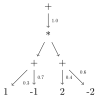

In [19]:
c1 = (+)((.3X1[1] + .7X1[2]) * (.4X2[1] + .6X2[2]))
plot(c1)

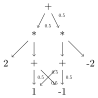

In [20]:
c2, _ = split(c1, (c1, c1.children[1]), Var(2);depth=2)
plot(c2)

6. **Clone**

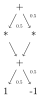

In [21]:
or = X1[1] + X1[2]
and1, and2 = (*)(or), (*)(or)
c1 = and1 + and2
c2 = clone(c1, and1, and2, or)
plot(c1)

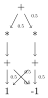

In [22]:
plot(c2)

7. **Merge**

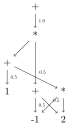

In [23]:
or1 = X1[1] + (X1[2] & X2[1])
or2 = X1[2] + X2[1]
c1 = (+)(or1 * or2)
c2 = merge(c1, or1, or2)
plot(c1)

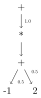

In [24]:
plot(c2)

## Circuit Queries
### Logical queries
1. If the data satisfies circuit logical formula? 

In [25]:
input = DataFrame(BitArray([1 1 0; 1 0 1]))
println(tree_formula_string(pc))
satisfies(pc, input)

((1 ⋀ (2 ⋁ -3)) ⋁ (-1 ⋀ (-2 ⋁ 3)))


2-element BitArray{1}:
 1
 0

2. Model counting of circuit logical formula

In [26]:
model_count(pc)

8

### Probabilistic queries

Some helper functions, you can skip them.

In [27]:
# You can skip this part. Includes helper functions to make partial observations from arrays of strings
# so its easier to present.

# Make one observation from list of string describing the observation
#
# For example, ["smoker", "male"] sets 
#   1) The mentioned features to the correct values.
#   2) Every feature not mentioned to missing values. 
FEATURES = 36;
function make_one_observation(obs)
    result = missings(Bool, FEATURES)
    for k in obs
        # Smoking
        if lowercase(k) == "smoker"
            result[7:8] .= [0, 1]
        elseif lowercase(k) == "!smoker"
            result[7:8] .= [1, 0]
        # Gender
        elseif lowercase(k) == "male"
            result[13:14] .= [1, 0]
        elseif lowercase(k) == "female"
            result[13:14] .= [0, 1]
        # Region
        elseif lowercase(k) == "southeast"
            result[9:12] .= [0, 0, 1, 0]
        elseif lowercase(k) == "southwest"
            result[9:12] .= [0, 1, 0, 0]
        # Child
        elseif lowercase(k) == "1-child"
            result[1:6] .= [0,1,0,0,0,0]
        end
    end
    result
end;

function make_observations(obs)
    count = size(obs)[1]
    result = missings(Bool, count, FEATURES)
    for i=1:count
        result[i, :] .= make_one_observation(obs[i])
    end
    DataFrame(result)
end;

function flip_coin(d::DataFrame; keep_prob=0.8)
    m = missings(Bool, num_examples(d), num_features(d))
    flag = rand(num_examples(d), num_features(d)) .<= keep_prob
    m[flag] .= Matrix(d)[flag]
    DataFrame(m)
end;


loading data

In [28]:
using CSV
train_x = DataFrame(BitArray(Matrix(CSV.read("insurance/insurance_train_x.csv", DataFrame))))
train_y = CSV.read("insurance/insurance_train_y.csv", DataFrame);

println("\"Insurance\" training set has $(num_features(train_x)) variables and $(num_examples(train_x)) samples.")

"Insurance" training set has 36 variables and 935 samples.


load a pretrained probabilistic circuit (automatically downloaded through Julia Artifacts)
  - Original Files can be found here https://github.com/UCLA-StarAI/Circuit-Model-Zoo


In [29]:
pc = load_prob_circuit(zoo_psdd_file("insurance.psdd"))
println("Probablistic Circuit with $(num_nodes(pc)) nodes and $(num_parameters(pc)) parameters.")

Probablistic Circuit with 27493 nodes and 16272 parameters.


#### EVI: Complete Evidence Query

All features are observed, we want to compute the probability: $P(x)$

In [30]:
log_likelihood_avg(pc, train_x)

-9.71171374929969

#### MAR: Marginal Query (partial evidence)

Now, what happens if we only observe a subset of the features $X^o$? We want to compute: $ P(X^o) = \sum_{x^m} P(X^o X^m) $

**Problem:** Computing above query is usually not tractable as it involves summing over exponential (infinite) possible worlds.

**Good News:** In probabilistic circuits, if the circuit is **smooth** and **decomposable**, we can do this tractably. No need to enumerate all possible worlds.

In [31]:
marg_data = make_observations([["smoker"], 
                       ["female"], 
                       ["female", "smoker"], 
                       ["southeast", "male", "1-child", "smoker"]],
                    )
prob = exp.(marginal(pc, marg_data))
println("Probability of being smoker? ", prob[1])
println("Probability of being female smoker? ", prob[3])
println("Probability of being male smoker with one child living in the southeast? ", prob[4])

Probability of being smoker? 0.18403563
Probability of being female smoker? 0.096237846
Probability of being male smoker with one child living in the southeast? 0.0009639263


#### CON: Conditional Queries

Given some observations $X^o$, we want to compute probabilities conditioned on the observations: $ P(Q \mid X^o) $
if we can do marginals tractably, we can also do conditionals tractably: $ P(Q \mid X^o) = \cfrac{P(Q, X^o)}{P(X^o)} $

In [32]:
println(" P('smoker' | 'female') = $(prob[3]/prob[2])")

 P('smoker' | 'female') = 0.20398751


#### Advanced queries: expected predictions

We have two separate models $p$ and $f$. $p$ is a generative model representing some distributions, and $f$ is a predictive model. We are interested in computing **expected predictions** of $f$ according to the distribution encoded by $g$.

- Appears all the time in machine learning, such as handling missing data
- We can do this tractably!


$ \Large \mathbb{E}_{\mathbf{x}^m\ \sim\ p(\mathbf{x}^m\ \mid\ \mathbf{x}^o )}\left[\ f( \mathbf{x}^o \mathbf{x}^m) \ \right] $

- In above equation $ \mathbf{x}^m $ = missing features, and $ \mathbf{x}^o $ = observed features.

- Expected Prediction useful for:
  - Handling missing values at test time
  - Reasoning about behaviour of predictive models

- load a regression circuit

In [33]:
rc = load_logistic_circuit(zoo_lc_file("insurance.circuit"), 1)
println("Regression Circuit with $(num_nodes(rc)) nodes.")

Regression Circuit with 1076 nodes.


##### Sample Queries
1. How different are the insurance costs between smokers and non smokers?

In [34]:
data = make_observations([["!smoker"], 
                 ["smoker"]])
exps, exp_cache = Expectation(pc, rc, data)
println("Non-Smoker: \$ $(exps[1])");
println("Smoker    : \$ $(exps[2])");
println("Difference: \$ $(exps[2] - exps[1])");

Non-Smoker: $ 8741.748
Smoker    : $ 31355.338
Difference: $ 22613.59


2. Is the predictive model biased by gender?

In [35]:
data = make_observations([["male"],
                 ["female"]])
exps, exp_cache = Expectation(pc, rc, data);
println("Female  : \$ $(exps[2])");
println("Male    : \$ $(exps[1])");
println("Diff    : \$ $(exps[2] - exps[1])");

Female  : $ 14170.123
Male    : $ 13196.557
Diff    : $ 973.5664


3. Expecation and standard devation of few subpopulations

In [36]:
data = make_observations( [["southeast", "male", "1-child", "smoker"], 
                 ["southwest", "male", "1-child", "smoker"]])
exps, exp_cache = Expectation(pc, rc, data);
# Computes the second moment
mom2, mom_cache = Moment(pc, rc, data, 2);
# Computing Standard Deviation
stds = sqrt.( mom2 - exps.^2 );
# Living in South East, Smoker, Male, One child
println("mu: $(round(exps[1])), std = $(round(stds[1]))")

mu: 30975.0, std = 11229.0


## Parameter Learning and Structure learning
### Parameter Learning
1. load data and create a fully factorized circuit

In [37]:
train_x, valid_x, test_x = twenty_datasets("nltcs")
v = Vtree(num_features(train_x), :balanced)
pc = fully_factorized_circuit(StructProbCircuit, v);

2. Maximum likelihood estimate parameters (MLE) given complete data

In [38]:
estimate_parameters(pc, train_x; pseudocount=1.0);
println("Training set log-likelihood is ", log_likelihood_avg(pc, train_x))

Training set log-likelihood is -9.270330518351884


### Structure learn
#### Initializations
- Initialized from a Chow-Liu Tree

In [39]:
pc, vtree = learn_chow_liu_tree_circuit(train_x)
println("Initial circuits has $(num_nodes(pc)) nodes, $(num_parameters(pc)) parameters.")
println("Training set log-likelihood is ", log_likelihood_avg(pc, train_x))

Initial circuits has 121 nodes, 74 parameters.
Training set log-likelihood is -6.7600561877106955


#### Strcuture update
- Perform greedy search based on some buid-in heuristics, you can also use customized strategies by writing the callback function

In [40]:
loss(circuit) = ProbabilisticCircuits.heuristic_loss(circuit, train_x)
pc = struct_learn(pc; 
    primitives=[split_step], 
    kwargs=Dict(split_step=>(loss=loss,)),
    maxiter=10)
estimate_parameters(pc, train_x; pseudocount=1.0)
println("Circuits has $(num_nodes(pc)) nodes, $(num_parameters(pc)) parameters.")
println("Training set log-likelihood is ", log_likelihood_avg(pc, train_x))

Circuits has 213 nodes, 136 parameters.
Training set log-likelihood is -6.531536485344027


## Benchmarks and GPU accelerated computing 

This part was benchmarked using a NVIDIA TITAN RTX.


Depending where the data is Juice automatically uses the correct implementation using Julia's multiple dispatch, so using the GPU version is as simple as moving the data to gpu `to_gpu` and then everything is is identical (maybe differ in more advanced cases).

#### Load circuit and data

In [41]:
pc = zoo_psdd("plants.psdd")
println("Load a circuit with $(num_nodes(pc)) nodes and $(num_parameters(pc)) parameters.")
data, _, _ = twenty_datasets("plants")
println("Load a data with $(num_features(data)) features and $(num_examples(data)) examples.")

Load a circuit with 153021 nodes and 91380 parameters.
Load a data with 69 features and 17412 examples.


#### Move data to GPU

In [42]:
gpu_data = to_gpu(data);

#### If the data satisty logical constrains ?

CPU

In [43]:
@btime satisfies($pc, $data);

  147.943 ms (927801 allocations: 189.69 MiB)


GPU

In [44]:
@btime satisfies($pc, $gpu_data);

  73.994 ms (929353 allocations: 57.81 MiB)


As we see, the GPU version is about 2x faster for `satisfies`.

#### EVI queries
CPU

In [45]:
@btime EVI($pc, $data);

  333.853 ms (1351524 allocations: 334.75 MiB)


GPU 

In [46]:
@btime EVI($pc, $gpu_data);

  118.363 ms (1354507 allocations: 70.86 MiB)


As we see, the GPU version is about 3x faster for `EVI`.

#### MAR queries
CPU 

In [47]:
data_miss = flip_coin(data)
@btime MAR($pc, $data_miss);

  4.328 s (6088570 allocations: 4.31 GiB)


GPU

In [48]:
# a. Everything in one batch
gpu_data_miss = to_gpu(data_miss);

# b. Use this instead for smaller batch size in case all data does not fit into gpu memory in one batch
# gpu_data_miss = to_gpu(batch(data_miss, 8192));

In [49]:
@btime MAR($pc, $gpu_data_miss);

  422.633 ms (6090571 allocations: 215.29 MiB)


As we see, the GPU version is about 10x faster for `MAR`.

#### Maximum likelihood estimate parameters (MLE) given complete data
CPU 

In [50]:
@btime estimate_parameters(pc, data; pseudocount=1.0);

  341.473 ms (1500255 allocations: 345.80 MiB)


GPU 

In [51]:
@btime estimate_parameters(pc, gpu_data; pseudocount=1.0);

  96.983 ms (1220808 allocations: 77.72 MiB)


#### Expectation maximization estimate parameters (EM) given data with missing values
CPU 

In [52]:
@btime params_cpu = estimate_parameters_em($pc, $data_miss; pseudocount=1.0);

  48.016 s (6472549 allocations: 14.55 GiB)


GPU

In [53]:
#@time params_gpu = estimate_parameters_em(pc, gpu_data_miss; pseudocount=1.0);

#### Expected Prediction Benchmark

In [54]:
pc = load_prob_circuit(zoo_psdd_file("insurance.psdd"));
rc = load_logistic_circuit(zoo_lc_file("insurance.circuit"), 1);
train_x = DataFrame(BitArray(Matrix(CSV.read("insurance/insurance_train_x.csv", DataFrame))))

data_miss = flip_coin(vcat(train_x, train_x));
data_miss2 = flip_coin(vcat(train_x, train_x));

CPU Version (Recursive)

In [55]:
@btime Expectation($pc, $rc, $data_miss);

  12.931 s (6413973 allocations: 5.30 GiB)


GPU Version (By compiling into  [BitCircuitPair](https://juice-jl.github.io/ProbabilisticCircuits.jl/dev/api/internals/probabilistic_circuits/#ProbabilisticCircuits.BitCircuitPair))

In [56]:
train_x_gpu = to_gpu(data_miss);

In [57]:
@btime ExpectationBit($pc, $rc, $train_x_gpu);

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/pashak/.julia/packages/GPUArrays/jhRU7/src/host/indexing.jl:43


  559.230 ms (2870863 allocations: 148.29 MiB)


As we see, the GPU version is about 20x faster than the recursive CPU version.

**Sidenote:** The gpu version is even faster for upcoming batches if we reuse the `ParamBitCircuitPair` and already allocated memory:

In [62]:
results, fvalues, gvalues, pbc = ExpectationBit(pc, rc, train_x_gpu; return_aux=true);

# Second batch
train_x_gpu2 = to_gpu(data_miss2)

In [63]:
@btime ExpectationBit($pbc, $pc, $rc, $train_x_gpu2, $fvalues, $gvalues); 

  56.083 ms (242437 allocations: 11.70 MiB)
